In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import norm_spa_vecs

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def numpy_bytes_to_str(lst):
    return [l.decode('utf-8') for l in lst]

In [3]:
with h5py.File("../data/fami_ia_full.h5py", "r") as fi:
    print(list(fi.keys()))
    inp = np.array(fi['input'])
    output = np.array(fi['output'])
    
    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    D = fi['vocab_vectors'].attrs['dimensions']
    
    accum = np.array(fi['accum'])
    clean = np.array(fi['clean'])
    clean_accum = np.array(fi['clean_accum'])
    de_out = np.array(fi['de_out'])

    dt = fi['t_range'].attrs['dt']
    t_range = np.arange(fi['t_range'][0], fi['t_range'][1], dt)
    t_pause = fi['t_range'].attrs['t_pause']
    t_present = fi['t_range'].attrs['t_present']

['accum', 'clean', 'clean_accum', 'correct', 'de_out', 'fan1', 'fan2', 'foil1', 'foil2', 'input', 'output', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
t_each = t_pause + t_present

In [5]:
vocab = spa.Vocabulary(D)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

In [6]:
fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [7]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

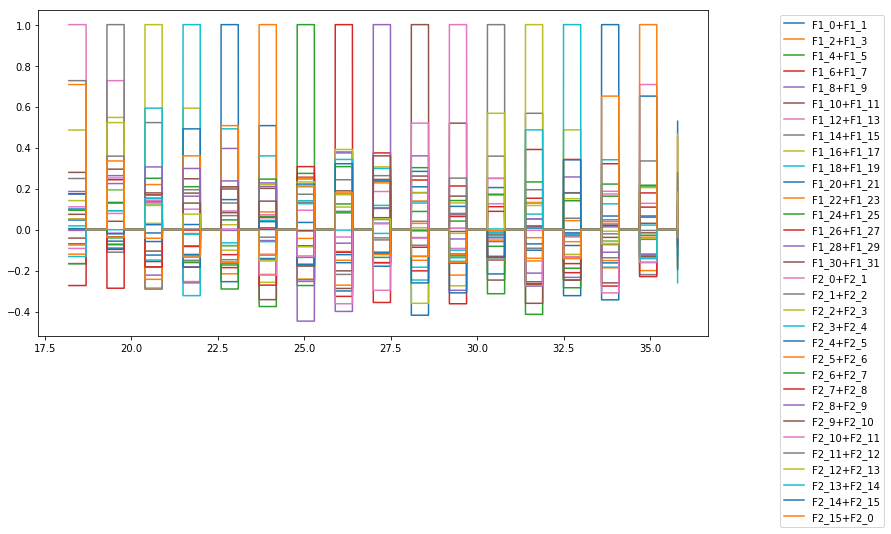

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

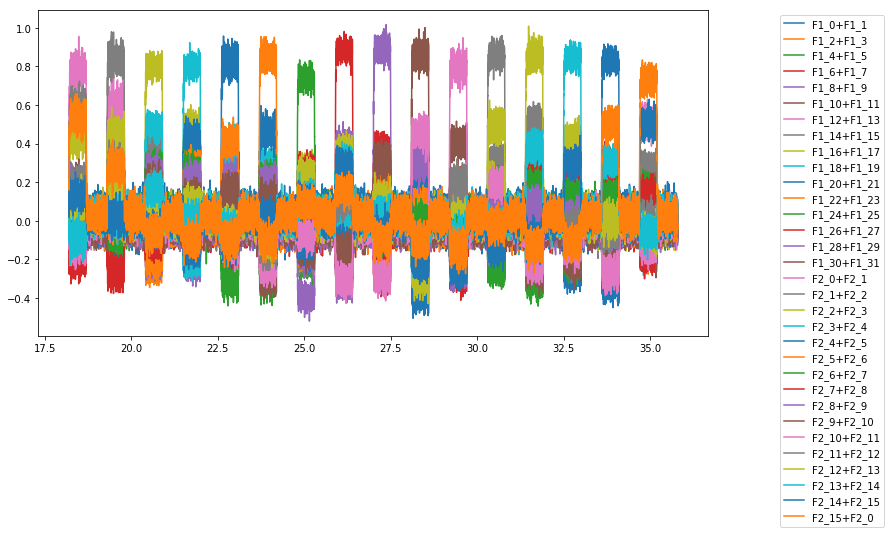

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(de_out, fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

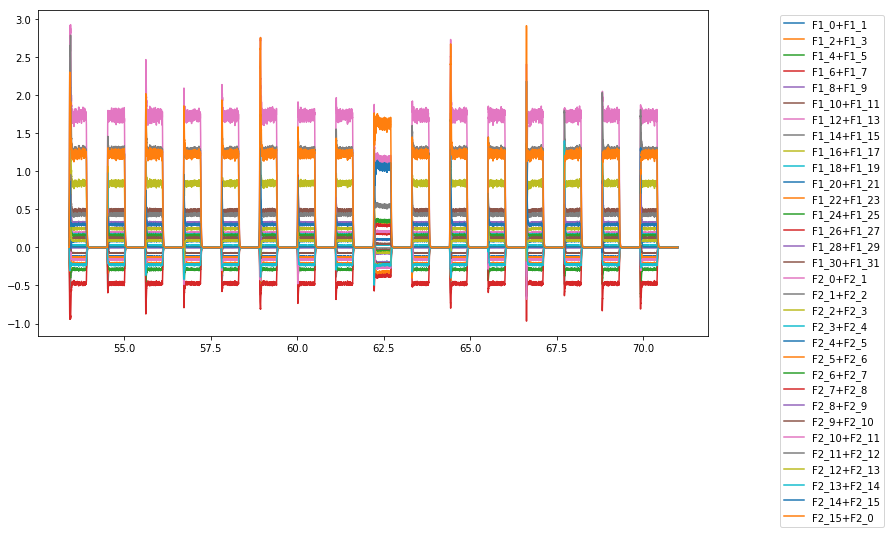

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[foil2_win], spa.similarity(clean, fan1_pair_vecs+fan2_pair_vecs)[foil2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

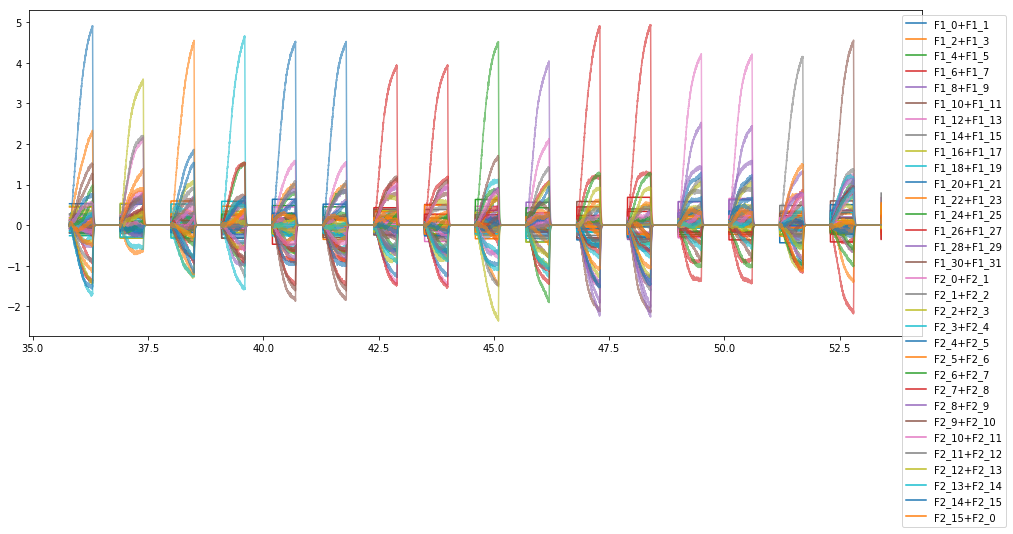

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(t_range[foil1_win], spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs)[foil1_win])
plt.gca().set_prop_cycle(None)
plt.plot(t_range[foil1_win], spa.similarity(accum, fan1_pair_vecs+fan2_pair_vecs)[foil1_win], alpha=0.6)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

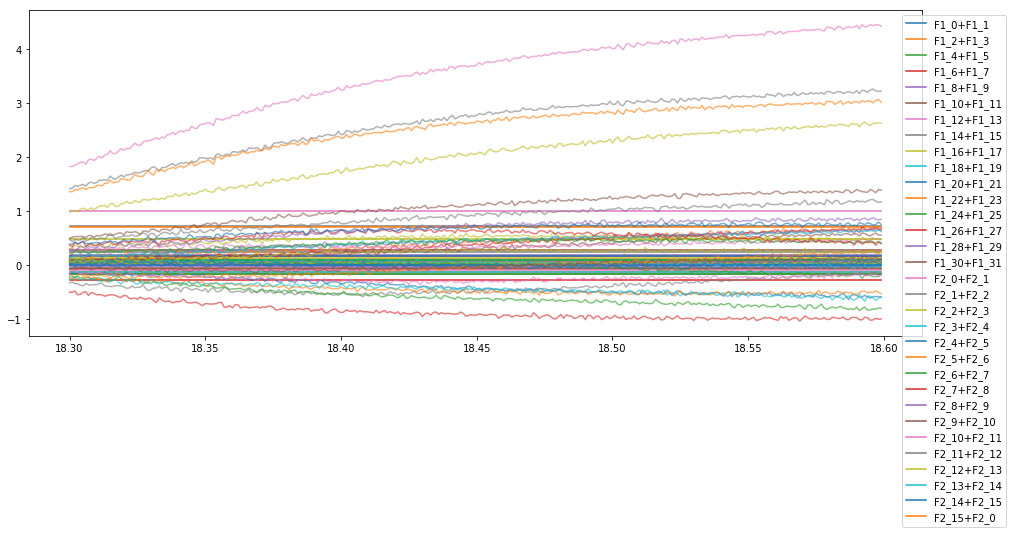

In [42]:
plt.figure(figsize=(16, 6))
plt.plot(t_range[fan2_win.start+100:fan2_win.start+400], spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs)[fan2_win.start+100:fan2_win.start+400])
plt.gca().set_prop_cycle(None)
plt.plot(t_range[fan2_win.start+100:fan2_win.start+400], spa.similarity(accum, fan1_pair_vecs+fan2_pair_vecs)[fan2_win.start+100:fan2_win.start+400], alpha=0.6)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

# Reaction Time

FAN1 should be faster than FAN2. Should be minimal difference between FAN and FOIL.

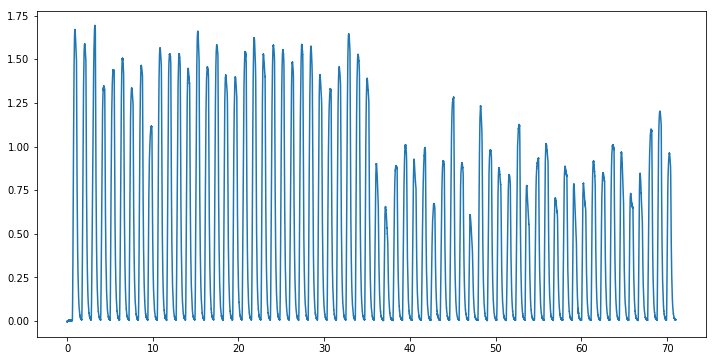

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, output)

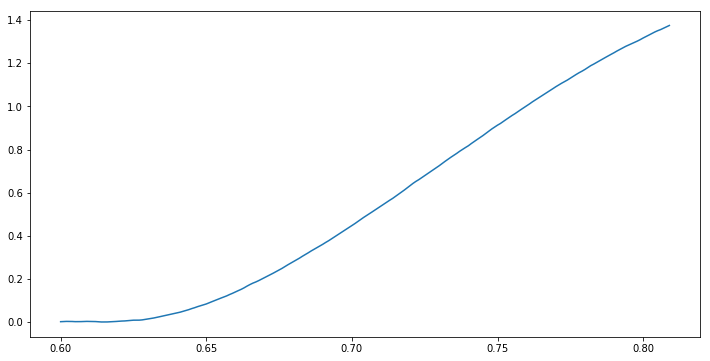

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[600:810], output[600:810])

In [15]:
all_vecs = vocab.parse("+".join(list(vocab.keys()))).v
all_vecs = all_vecs / np.linalg.norm(all_vecs)

In [18]:
inp[:100].shape

(100, 32)

In [43]:
f1_start = 1000
f2_start = fan2_win.start + 400

in_noise = all_vecs - inp
print(np.dot(inp[f1_start], accum[f1_start]))
print(np.dot(in_noise[f1_start], accum[f1_start]))
print(np.dot(inp[f2_start], accum[f2_start]))
print(np.dot(in_noise[f2_start], accum[f2_start]))

4.529040314195999
-3.741631997183802
4.442243078715163
-1.6613115154758402


# Error Rate

FAN1 should be more accurate than FAN2. Should be no difference between FAN and FOIL.